# t-distributed Stochastic Neighbor Embedding
- 고차원과 저차원의 데이터간 확률적인 관계를 같게 하고자 함 => 두 분포가 같다면 고차원에서의 특징이 저차원에서 잘 보존되어 있는 것
- Neighbor identity를 보존하는 방식으로 확률적(probabilistic)인 접근 방식을 사용
- SNE, symmetric SNE와 다르게 저차원 데이터의 유사성을 표현하는 결합확률로  `자유도 1의 t분포 사용`
</br>

## t-SNE의 장점
- PCA에 비해 경계가 분명하여 시각화 용도로 사용이 가능
- 데이터의 local 구조를 유지함과 동시에 일부 중요한 global 구조를 드러낼 수 있음
- 여러 scale에서 global 구조를 보여주어 군집의 존재를 확인할 수 있음
- SNE의 변형으로 최적화가 쉬움

## t-SNE의 약점
- 일반적인 차원 축소 방법에서 어떻게 수행되는지 명확하지 않음
- t-SNE는 상대적으로 local한 특성을 같기에 데이터의 본질적인 차원의 저주에 민감함
- 비용 함수가 전역 최적값으로 수렴하는 것이 보장되지 않음 (최적화 매개변수 및 초기 무작위 구성에 따라 매번 다른 결과 도출)

### 데이터 설명 및 t-SNE tutorial 순서
- 데이터 설명
    - Fashion MNIST
- Tutorial 순서
    1. 데이터에 바로 적용
    2. PCA 이후의 t-SNE
    3. CAE의 latent space에 대한 t-SNE

### 결과 해석
- PCA를 적용한 후의 t-SNE 결과와 바로 적용한 결과는 거의 유사하다. 그러나 PCA를 적용했을 때가 조금 더 밀집한 결과를 보여주며 소요시간도 크게 줄었다. Fashion MNIST 데이터의 경우 매우 고차원의 데이터라 볼 수 없기에 AutoEncode (AE)를 적용했을 때와 그러지 않았을 때의 결과 차이가 크지 않다. 눈에 띄는 차이점은 AE를 적용했을 때가 더 퍼져있다는 것이다. Fashion MNIST가 아닌 보다 고차원의 데이터에 대해서 절반 이상 줄인 latent space를 가지고 t-SNE를 적용해보면 유의미한 결과를 얻을 수 있을 것 같다.

- Perplexity를 5, 40, 120으로 하여 차이를 확인해 보았다. 논문의 저자는 5~50이 적당하다고 하였는데 80을 실험해 본 이유는 과연 어떤 차이점이 생기는지 궁금해서였다. [5, 40, 120]을 비교해보면 perplexity가 작을 수록 분포의 면적이 넓어지는 것을 알 수 있다. 또한 perplexity가 증가할 수록 군집 내의 거리는 가까워지고, 군집 간의 거리는 멀어졌다.

-------

### 1. 데이터에 바로 적용
- Visualization function reference link : https://www.datacamp.com/tutorial/introduction-t-sne

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns
import numpy as np
import random
import time

In [2]:
## 데이터 다운로드
root = './Fashion_MNIST'
batch_size = 128

transform = transforms.Compose([transforms.ToTensor()]) # 텐서 변환
train_data = dataset.FashionMNIST(root=root, train=True, transform=transform, download=True)
test_data = dataset.FashionMNIST(root=root, train=False, transform=transform, download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)

In [3]:
## t-SNE 입력 데이터
value_dataset = train_data.data.view(-1,784).numpy()
label_dataset = train_data.targets.numpy()

In [4]:
"""시각화 함수"""
def fashion_scatter(x, colors, perplexity):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(12, 12))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    plt.title(f'perplexity : {perplexity}', fontsize=20)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

c:\Users\RohSeungChan\Anaconda3\envs\torch-gpu\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\RohSeungChan\Anaconda3\envs\torch-gpu\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.042s...
[t-SNE] Computed neighbors for 60000 samples in 121.401s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional probabilities for s

c:\Users\RohSeungChan\Anaconda3\envs\torch-gpu\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


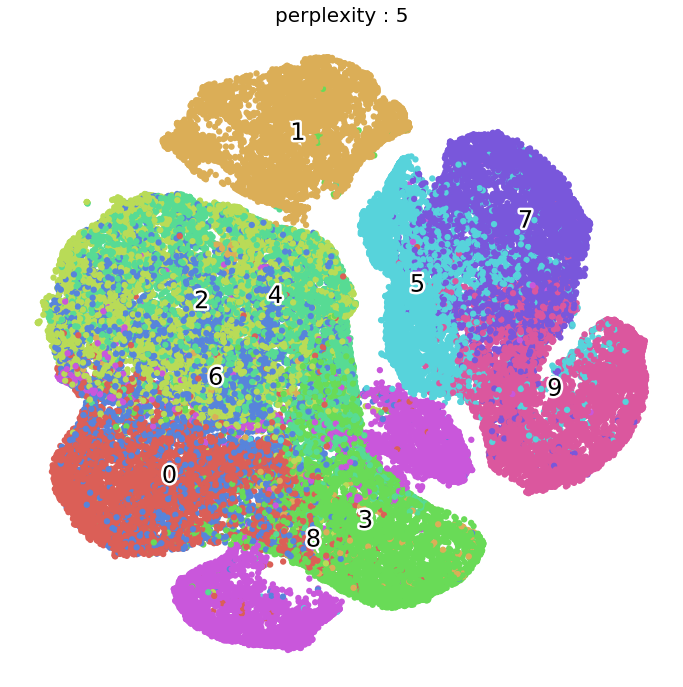

In [5]:
## t-SNE 적용
time_start = time.time() # 시간 계산
tsne_v = TSNE(n_components=2, verbose=1, n_iter=300, perplexity=5).fit_transform(value_dataset)
lead_time = time.time() - time_start

fashion_scatter(tsne_v, label_dataset, perplexity=5)
print('# 소요된 시간 :', lead_time)

------

### 2. PCA 이후의 t-SNE
- t-SNE 알고리즘의 fitting 시간 단축을 위해 PCA를 먼저 사용

In [6]:
## PCA로 30개의 주성분 추출
pca = PCA(n_components=30)
pca_components_30 = pca.fit_transform(value_dataset)
print(pca_components_30.shape)
print('# 30개 주성분의 분산 :', np.sum(pca.explained_variance_ratio_))

(60000, 30)
# 30개 주성분의 분산 : 0.8207231732478867


[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.003s...


c:\Users\RohSeungChan\Anaconda3\envs\torch-gpu\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\RohSeungChan\Anaconda3\envs\torch-gpu\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 60000 samples in 62.123s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional probabilities for sample 13000 / 60000
[t-SNE] Computed conditional probabilities for sample 14000 / 6000

c:\Users\RohSeungChan\Anaconda3\envs\torch-gpu\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


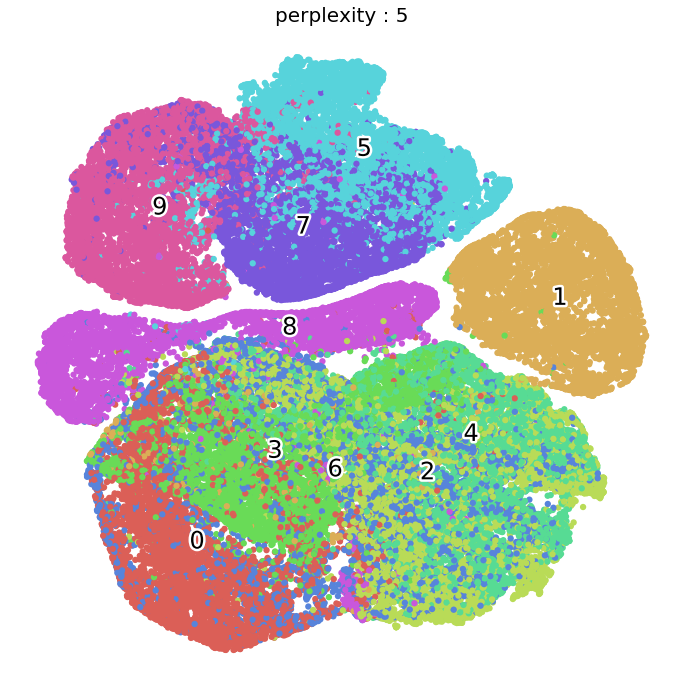

In [7]:
## 30개 주성분에 대한 PCA
    # 소요시간을 확인하기 위해서 다른 파라미터는 모두 같도록 설정
time_start = time.time() # 시간 계산
tsne_v = TSNE(n_components=2, verbose=1, n_iter=300, perplexity=5).fit_transform(pca_components_30)
lead_time = time.time() - time_start

fashion_scatter(tsne_v, label_dataset, perplexity=5)
print('# 소요된 시간 :', lead_time)

------

### 3. CAE의 latent space에 대한 t-SNE (데이터가 고차원인 경우 적용)
- t-SNE는 주로 데이터의 로컬 속성을 기반으로 데이터 차원을 줄이기에 본질적으로 차원의 저주에 민감하다. 매우 높은 고유 차원과 매우 다양한 기본 manifold가 잇는 데이터 세트에서 t-SNE가 암시적으로 만드는 manifold에 대한 로컬 선형성 가정이 위반될 수 있기 때문이다.

- 논문의 저자는 이러한 문제를 해결하기 위해 매우 다양한 매니폴드를 효율적으로 나타내는 오토인코더와 같은 모델로 얻은 데이터 표현에 대해 t-SNE를 수행하는 것을 추천한다. 오토 인코더를 통해 찾은 latent space는 t-SNE와 같은 local한 방법보다 더욱 다양한 manifold를 식별할 수 있기 때문에 구성된 시각화의 품질을 향상시킬 수 있다고 한다.

- 따라서 본 순서에서는 고차원인 fashion_mnist 데이터에 대해 `Convolutional AutoEncoder (CAE)를 적용해보고 거기서 얻은 latent space에 t-SNE를 적용`해보고자 한다.

- CAE model reference link : https://stackoverflow.com/questions/53858626/pytorch-convolutional-autoencoders

In [8]:
LATENT_SPACE_size = 196 # 25% 사이즈로 축소

class View_dimension(nn.Module):
    def __init__(self, shape):
        super(View_dimension, self).__init__()
        self.shape = shape
    def forward(self, x):
        return x.view(*self.shape)

"""모델 정의 CAE"""
## 향후 latent space를 사용하기 편하도록 인코더와 디코더 분리
class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2),
            View_dimension((-1,7*7*64)),
            nn.Linear(7*7*64, LATENT_SPACE_size),
            nn.LeakyReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(LATENT_SPACE_size, 7*7*64),
            nn.LeakyReLU(),
            View_dimension((-1, 64, 7, 7)),
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1, bias=False),
            nn.LeakyReLU()
        )
    def forward(self, x):
        out = self.encoder(x)
        out = self.decoder(out)
        return out

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CAE().to(device)
loss_func = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters())
scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma= 0.99)   

In [10]:
num_epochs = 20

for i in range(num_epochs):
    for _, [image, _] in enumerate(train_loader):
        x = image.to(device)
        y_= image.to(device)
        
        optimizer.zero_grad()
        output = model(x)
        loss = loss_func(output, y_)
        loss.backward()
        optimizer.step()
 
    scheduler.step(loss)      
    print('Epoch: {}, Loss: {}, Learning Rate: {}'.format(i, loss.item(), scheduler.optimizer.state_dict()['param_groups'][0]['lr']))

c:\Users\RohSeungChan\Anaconda3\envs\torch-gpu\lib\site-packages\torch\optim\lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 0, Loss: 0.013658775947988033, Learning Rate: 0.0010000000474974513
Epoch: 1, Loss: 0.012183761224150658, Learning Rate: 0.0010000000474974513
Epoch: 2, Loss: 0.01022531557828188, Learning Rate: 0.0010000000474974513
Epoch: 3, Loss: 0.009264583699405193, Learning Rate: 0.0010000000474974513
Epoch: 4, Loss: 0.008164952509105206, Learning Rate: 0.0010000000474974513
Epoch: 5, Loss: 0.008497416973114014, Learning Rate: 0.0010000000474974513
Epoch: 6, Loss: 0.006967755034565926, Learning Rate: 0.0010000000474974513
Epoch: 7, Loss: 0.006663281004875898, Learning Rate: 0.0010000000474974513
Epoch: 8, Loss: 0.006484371144324541, Learning Rate: 0.0010000000474974513
Epoch: 9, Loss: 0.006152525078505278, Learning Rate: 0.0010000000474974513
Epoch: 10, Loss: 0.006329994183033705, Learning Rate: 0.0010000000474974513
Epoch: 11, Loss: 0.005192609503865242, Learning Rate: 0.0010000000474974513
Epoch: 12, Loss: 0.005914079956710339, Learning Rate: 0.0010000000474974513
Epoch: 13, Loss: 0.0054

tensor(3)
tensor(7)
tensor(1)


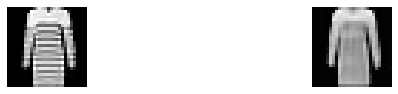

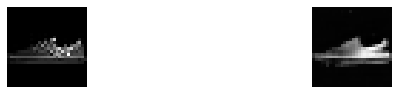

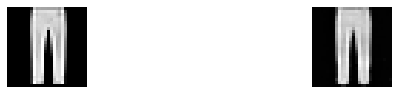

In [11]:
## 복원된 이미지 확인
    # 왼쪽 입력 이미지 vs 오른쪽 복원 이미지
model.eval()
rows = 3
for c in range(rows):
    plt.figure(figsize = (10,5))
    plt.subplot(rows, 2, c*2+1)
    rand_idx = random.randint(0, test_data.data.shape[0])
    plt.imshow(test_data.data[rand_idx].view(28,28), cmap='gray')
    plt.axis('off')
    plt.subplot(rows, 2, c*2+2)
    inp = transform(test_data.data[rand_idx].numpy().reshape(28,28)).reshape(1,1,28,28).to(device)
    img = model(inp)
    plt.imshow(img.view(28,28).detach().cpu().numpy(), cmap='gray')
    plt.axis('off')
    print(test_data.targets[rand_idx])
plt.show()

In [12]:
"""test data를 인코더에 넣어 latent space 얻기"""
## CAE의 인코더를 통해 매니폴드를 얻고 이후 t-SNE 사용
t_SNE_input = transform(test_data.data.numpy().reshape(-1,28,28))
t_SNE_input = t_SNE_input.transpose(0,1) # batch를 맨 앞으로 설정
t_SNE_input = t_SNE_input.reshape(-1,1,28,28).to(device) # ipnut 차원 만들기
z = model.encoder(t_SNE_input) # CAE의 인코더 사용
z = z.detach().cpu().numpy()
y = test_data.targets.numpy()
print('축소된 차원의 shape: ', z.shape)

축소된 차원의 shape:  (10000, 196)


[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.002s...


c:\Users\RohSeungChan\Anaconda3\envs\torch-gpu\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\RohSeungChan\Anaconda3\envs\torch-gpu\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 10000 samples in 2.226s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.475006
[t-SNE] KL divergence after 250 iterations with early exaggeration: 92.442375
[t-SNE] KL divergence after 300 iterations: 3.990774
# 소요된 시간 : 13.830250024795532


c:\Users\RohSeungChan\Anaconda3\envs\torch-gpu\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


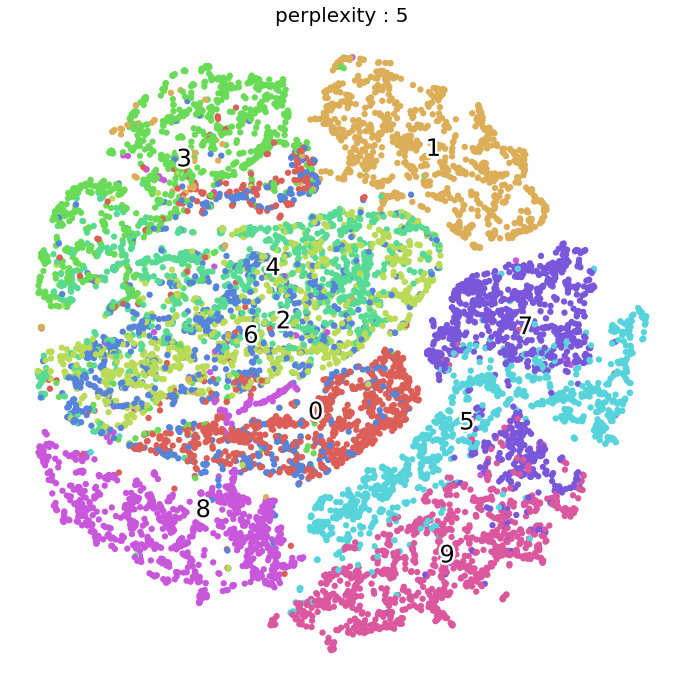

In [13]:
"""최근접 이웃 수를 늘려가면서 해보기 : [5, 40, 80]"""
## perplexity = 5
time_start = time.time() # 시간 계산
tsne = TSNE(n_components=2, verbose=1, n_iter=300, perplexity=5)
tsne_v = tsne.fit_transform(z) # 모든 학습 데이터 다 사용
lead_time = time.time() - time_start

## Visualization
fashion_scatter(tsne_v, y, perplexity=5)
print('# 소요된 시간 :', lead_time)

c:\Users\RohSeungChan\Anaconda3\envs\torch-gpu\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\RohSeungChan\Anaconda3\envs\torch-gpu\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.002s...
[t-SNE] Computed neighbors for 10000 samples in 2.131s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.475006
[t-SNE] KL divergence after 250 iterations with early exaggeration: 92.259361
[t-SNE] KL divergence after 300 iterations: 3.987691
# 소요된 시간 : 13.970195770263

c:\Users\RohSeungChan\Anaconda3\envs\torch-gpu\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


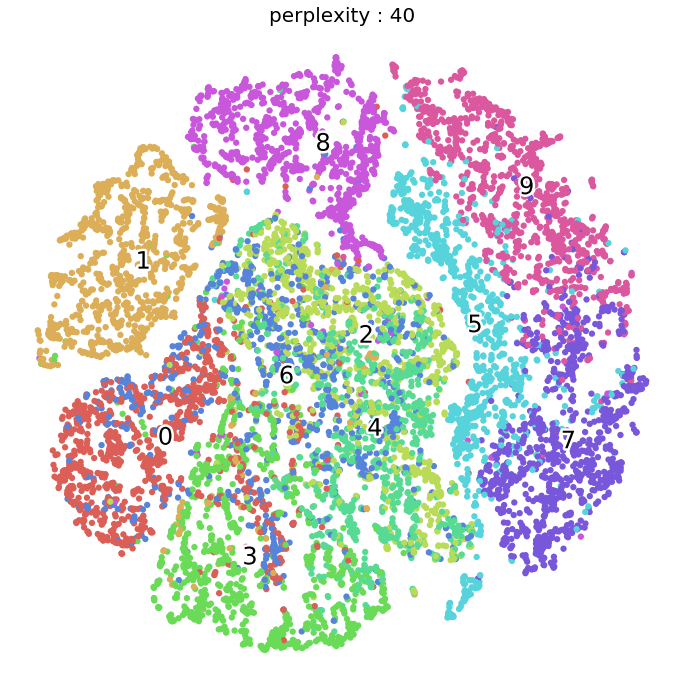

In [14]:
"""최근접 이웃 수를 늘려가면서 해보기 : [5, 40, 80]"""
## perplexity = 40
time_start = time.time() # 시간 계산
tsne = TSNE(n_components=2, verbose=1, n_iter=300, perplexity=5)
tsne_v = tsne.fit_transform(z) # 모든 학습 데이터 다 사용
lead_time = time.time() - time_start

## Visualization
fashion_scatter(tsne_v, y, perplexity=40)
print('# 소요된 시간 :', lead_time)

c:\Users\RohSeungChan\Anaconda3\envs\torch-gpu\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\RohSeungChan\Anaconda3\envs\torch-gpu\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.002s...
[t-SNE] Computed neighbors for 10000 samples in 2.416s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.884600
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.451851
[t-SNE] KL divergence after 300 iterations: 2.029245
# 소요된 시간 : 24.02013659477

c:\Users\RohSeungChan\Anaconda3\envs\torch-gpu\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


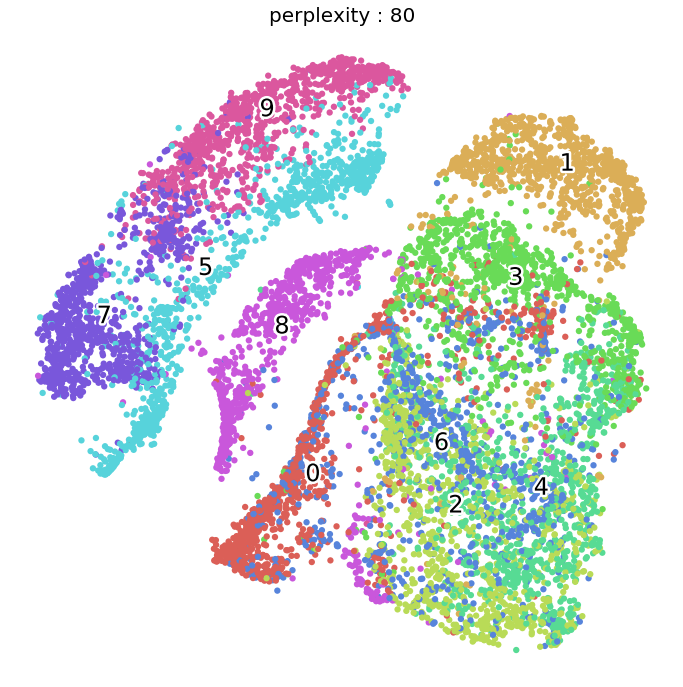

In [15]:
"""최근접 이웃 수를 늘려가면서 해보기 : [5, 40, 80]"""
## perplexity = 80
time_start = time.time() # 시간 계산
tsne = TSNE(n_components=2, verbose=1, n_iter=300, perplexity=80)
tsne_v = tsne.fit_transform(z) # 모든 학습 데이터 다 사용
lead_time = time.time() - time_start

## Visualization
fashion_scatter(tsne_v, y, perplexity=80)
print('# 소요된 시간 :', lead_time)